In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.patches as mpatches
from scipy.spatial.distance import cdist

import networkx as nx
from scipy.spatial.distance import jaccard
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15

# Process LARRY data

In [109]:
invitro_data_dir = '../data/larry/'
df_meta = pd.read_csv(f'{invitro_data_dir}input/stateFate_inVitro_metadata.txt', sep='\t')

In [110]:
ntypes = df_meta['Cell type annotation'].nunique()
cell_type_list = list(df_meta['Cell type annotation'].unique())
cell_type_index_dict = {cell_type: idx for idx, cell_type in enumerate(cell_type_list)}

In [111]:
barcoded_cells = []

with open(f'{invitro_data_dir}/input/stateFate_inVitro_clone_matrix.mtx', 'r') as inp:
    flag = 0
    for line in inp:
        if line.startswith('%'):
            continue
        data = line.rstrip('\n').split(' ')
        assert(len(data) == 3)
        if flag == 0:
            nclones = int(data[1])
            orig_clone_type_mat = np.zeros((nclones, ntypes))
            flag = 1
        else:
            cell_idx = int(data[0]) - 1
            clone_idx = int(data[1]) - 1
            cell_type_idx = cell_type_index_dict[df_meta.iloc[cell_idx]['Cell type annotation']]
            barcoded_cells.append(cell_idx)
            orig_clone_type_mat[clone_idx][cell_type_idx] = 1

In [112]:
df_meta_altered = df_meta.copy()

df_meta_altered['barcoded'] = 0
df_meta_altered.loc[barcoded_cells, 'barcoded'] = 1

df_meta_altered[df_meta_altered['barcoded'] == 1]['Cell type annotation'].value_counts()

df_orig_clone_type_mat = pd.DataFrame(orig_clone_type_mat, columns = cell_type_list, dtype=int)

df_collapsed_clone_type_mat = df_orig_clone_type_mat.copy()

df_collapsed_clone_type_mat['DC'] = df_collapsed_clone_type_mat['Ccr7_DC'] | df_collapsed_clone_type_mat['pDC']
df_collapsed_clone_type_mat = df_collapsed_clone_type_mat.drop(['Ccr7_DC', 'pDC'], axis=1)

In [114]:
deduplicated_collapsed_clone_type_mat, collapsed_clone_type_inverse_indices, collapsed_clone_counts = np.unique(df_collapsed_clone_type_mat.values,
                                                                                                                axis=0,
                                                                                                                return_inverse=True,
                                                                                                                return_counts=True)

df_deduplicated_collapsed_clone_type_mat = pd.DataFrame(deduplicated_collapsed_clone_type_mat,
                                                        columns = df_collapsed_clone_type_mat.columns,
                                                        dtype = int)

df_deduplicated_collapsed_clone_type_mat['counts'] = collapsed_clone_counts

# df_deduplicated_collapsed_clone_type_mat.to_csv('../data/larry/input/collapsed_clone_type_mat.csv')


# with open('../data/larry/input/collapsed_clone_type_inverse_indices.txt', 'w') as out:
#     for idx in collapsed_clone_type_inverse_indices:
#         out.write(f'{idx}\n')

# Figure 4a

In [2]:
invitro_data_dir = '../data/larry/'
df_meta = pd.read_csv(f'{invitro_data_dir}input/stateFate_inVitro_metadata.txt', sep='\t')

In [3]:
my_pallete_collapsed = {'Undifferentiated': '#E5E4E2',
              'Monocyte': sns.color_palette()[0],
              'Neutrophil': sns.color_palette()[1],
              'Baso': sns.color_palette()[2], 
              'Eos': sns.color_palette()[3],
              'Mast': sns.color_palette()[4],
              'Meg': sns.color_palette()[5],
              'Erythroid': sns.color_palette()[6],
              'Lymphoid': sns.color_palette()[8],
              'DC': sns.color_palette()[9],
             }

In [4]:
df_meta_collapsed = df_meta.copy()
df_meta_collapsed.loc[df_meta_collapsed['Cell type annotation'] == 'Ccr7_DC', 'Cell type annotation'] = 'DC'
df_meta_collapsed.loc[df_meta_collapsed['Cell type annotation'] == 'pDC', 'Cell type annotation'] = 'DC'

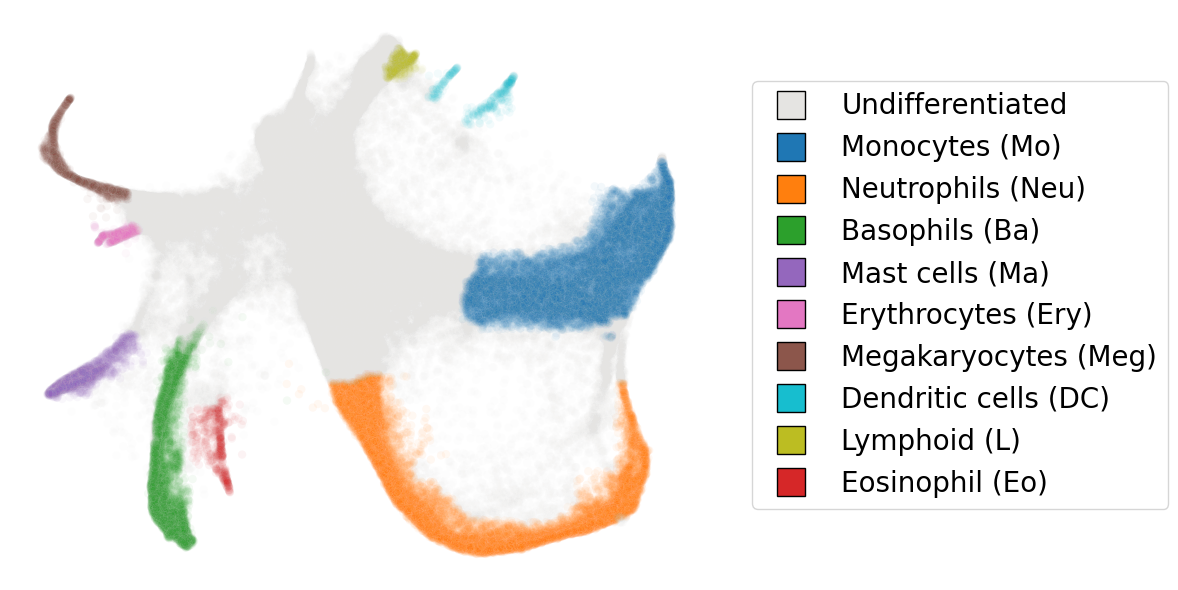

In [5]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
g = sns.scatterplot(data=df_meta_collapsed, x='SPRING-x', y='SPRING-y', alpha=0.05, hue='Cell type annotation',
                    palette=my_pallete_collapsed)

handles, labels =  g.get_legend_handles_labels()

for idx in range(len(handles)):
    handles[idx] = plt.Line2D([], [], color=handles[idx].get_color(),
                              marker='s', linestyle='', markersize=20, markeredgecolor='k')
new_labels = ['Undifferentiated', 'Monocytes (Mo)', 'Neutrophils (Neu)', 'Basophils (Ba)', 'Mast cells (Ma)', 'Erythrocytes (Ery)',
              'Megakaryocytes (Meg)','Dendritic cells (DC)', 'Lymphoid (L)', 'Eosinophil (Eo)']
g.legend(handles, new_labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fontsize=20,)

ax.tick_params(axis='y',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               left=False,      # ticks along the bottom edge are off
               right=False,         # ticks along the top edge are off
               labelleft=False) # labels along the bottom edge are off
ax.set_ylabel('');

ax.tick_params(axis='x',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               bottom=False,      # ticks along the bottom edge are off
               top=False,         # ticks along the top edge are off
               labelbottom=False) # labels along the bottom edge are off
ax.set_xlabel('');

ax.axis('off');
plt.tight_layout()
fig.patch.set_facecolor('white')

# Figure 4b

In [6]:
normalization_factor = 560

In [8]:
df_dag_disc = pd.read_csv("../data/larry/results/larry_dag_discrepancies.csv", sep = '\t')
df_dag_disc.columns = ['k', 'discrepancy']
df_dag_disc['discrepancy'] = [d/normalization_factor for d in df_dag_disc['discrepancy']]

In [9]:
carta_tree_disc_data = []
for nprogs in range(1, 11):
    with open(f'../data/larry/results/tree/collapsed_k{nprogs}_t10.log') as inp:
        for line in inp:
            continue
    carta_tree_disc_data.append([nprogs, float(line.rstrip('\n'))/normalization_factor])
    # print(nprogs, line, sep='\t')

In [10]:
df_tree_disc = pd.DataFrame(carta_tree_disc_data, columns = ['k', 'discrepancy'])

In [12]:
# discrepancy_df = pd.read_csv("LARRY_method_discrepancies.txt", index_col = 0)
df_disc = pd.read_csv("../data/larry/results/LARRY_method_discrepancies_pruned.txt", index_col = 0)

df_disc['discrepancy'] = [d/normalization_factor for d in df_disc['discrepancy']]

In [13]:
carta_k = 7

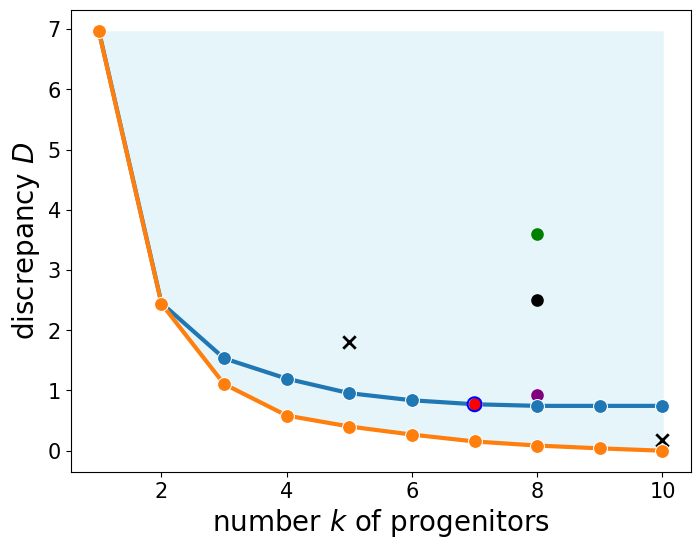

In [15]:
plt.fill_between(df_dag_disc['k'], df_dag_disc['discrepancy'], max(df_dag_disc['discrepancy']), color='#e5f5f9')
plt.fill_between(df_tree_disc['k'], df_tree_disc['discrepancy'], df_tree_disc['discrepancy'], color='#FEE8C6')
sns.lineplot(df_tree_disc, x='k', y='discrepancy', linewidth=3, marker='o', markersize=10)
sns.lineplot(df_dag_disc, x='k', y='discrepancy', linewidth=3, marker='o', markersize=10)

for i, row in df_disc.iterrows():
#     plt.text(row[2] + 0.25, row[1] - 0.05, s = row[0])
    if row.iloc[0] == "ICE-FASE":
        plt.scatter(row.iloc[2], row.iloc[1], marker='o', linewidth=2.0, s = 50, c = 'purple')
    elif row.iloc[0] == "EvoC":
        plt.scatter(row.iloc[2], row.iloc[1], marker='o', linewidth=2.0, s = 50, c = 'green')
    elif row.iloc[0] == "Weinreb":
        plt.scatter(row.iloc[2], row.iloc[1], marker='o', linewidth=2.0, s = 50, c = 'black')
    else:
        plt.scatter(row.iloc[2], row.iloc[1], marker='x', linewidth=2.0, s = 80, c = 'black')

# plt.scatter(carta_k, dag_res[carta_k - 1]/num_cells, marker='*', linewidth=2.0, s = 250, color = 'black', zorder = 5)
# plt.text(carta_k + 0.25, df_data2['discrepancy'][carta_k - 1] + 0.002, s = "Carta DAG")
# plt.axvline(9, 0, 1, linestyle = "--", zorder = 1)
# plt.text(9 + 0.1, 0 + 0.05, s = "Binary Tree")
plt.scatter(carta_k, df_tree_disc['discrepancy'][carta_k - 1], marker='o', linewidth=1.5, s = 100, facecolors='none', color = 'blue', zorder = 5)
plt.scatter(carta_k, df_tree_disc['discrepancy'][carta_k - 1], marker='o', linewidth=2.0, s = 50, color = 'red', zorder = 4)

plt.gcf().set_size_inches((8,6))
plt.gca().set_xlabel(r'number $k$ of progenitors', fontsize=20);
plt.gca().set_ylabel(r'discrepancy $D$', fontsize=20);
# plt.savefig("final_LARRY_overview_panel.png", dpi = 300)
# plt.show()

# Figure 4c

In [16]:
df_list = []

for nprogs in range(1, 11):
    df_sola = pd.read_csv(f'../data/larry/results/tree/collapsed_k{nprogs}_t10_tree_prog.csv', index_col = 0)
    df_sola['k'] = nprogs
    df_sola['index'] = range(len(df_sola))
    df_list.append(df_sola)

In [17]:
df_solutions = pd.concat(df_list, ignore_index=True)

In [18]:
df_input = pd.read_csv('../data/larry/input/collapsed_clone_type_mat.csv', index_col = 0)
df_input = df_input[df_input['counts'] >= 10]
df_input = df_input[df_input.values[:,1:-1].sum(axis=1) > 1]

In [20]:
viz_graph = nx.DiGraph()

for nprogs in range(1, 8):
    source_k = nprogs
    target_k = nprogs + 1

    df_source_assignment = pd.read_csv(f'../data/larry/results/tree/collapsed_k{source_k}_t10_tree_assignment.csv', index_col = 0)
    df_target_assignment = pd.read_csv(f'../data/larry/results/tree/collapsed_k{target_k}_t10_tree_assignment.csv', index_col = 0)

    for source_prog in range(source_k):
        source_clones = set(df_source_assignment[df_source_assignment[str(source_prog)] == 1].index)
        
        assert(len(df_solutions[(df_solutions['k'] == source_k) & (df_solutions['index'] == source_prog)].index) == 1)
        source_idx = df_solutions[(df_solutions['k'] == source_k) & (df_solutions['index'] == source_prog)].index[0]
        
        for target_prog in range(target_k):
            target_clones = set(df_target_assignment[df_target_assignment[str(target_prog)] == 1].index)
    
            target_idx = df_solutions[(df_solutions['k'] == target_k) & (df_solutions['index'] == target_prog)].index[0]
    
            curr_weight = df_input.loc[list(source_clones.intersection(target_clones))]['counts'].sum()
            if curr_weight > 0:
                viz_graph.add_edge(source_idx, target_idx, weight = curr_weight)    

In [21]:
for edge in viz_graph.edges:
    (viz_graph.get_edge_data(edge[0], edge[1])['weight'])

In [22]:
prog_label_color_dict = {'MPP': '#E5E4E2',
                         'MPPc': sns.color_palette(palette='RdYlBu').as_hex()[-1],
                         'CMP': sns.color_palette(palette='PuOr').as_hex()[0],
                         'CMP-DC': sns.color_palette(palette='Set2').as_hex()[5],
                         'Myeloblast': sns.color_palette(palette='Set2').as_hex()[6],
                         'Neu-Mo-Baso': sns.color_palette(palette='Set2').as_hex()[4],
                         'Neu-Mo': sns.color_palette(palette='PiYG').as_hex()[0],
                         'Baso-Eos': sns.color_palette(palette='PuOr').as_hex()[-1],
                         'MEP': sns.color_palette(palette='PiYG').as_hex()[-1]}

In [23]:
label_list = []
for row_idx, row in df_solutions[df_solutions['k'] <= 8].iterrows():
    row_vector = row[:-2]
    if np.array_equal(row_vector.values, [1]*9):
        label_list.append('MPP')
    elif np.array_equal(row_vector.values, [1,1,1,1,0,0,1,1,1]):
        label_list.append('MPPc')
    elif np.array_equal(row_vector.values, [1,1,0,0,0,0,0,0,0]):
        label_list.append('Neu-Mo')
    elif np.array_equal(row_vector.values, [0,0,1,0,0,0,0,1,0]):
        label_list.append('Baso-Eos')
    elif np.array_equal(row_vector.values, [1,1,1,1,0,0,0,1,0]):
        label_list.append('CMP')
    elif np.array_equal(row_vector.values, [0,0,0,0,1,1,0,0,0]):
        label_list.append('MEP')
    elif np.array_equal(row_vector.values, [1,1,1,0,0,0,0,1,0]):
        label_list.append('Myeloblast')
    elif np.array_equal(row_vector.values, [1,1,1,1,0,0,0,1,1]):
        label_list.append('CMP-DC')
    elif np.array_equal(row_vector.values, [1,1,1,0,0,0,0,0,0]):
        label_list.append('Neu-Mo-Baso')
    else:
        label_list.append('NA')

In [24]:
color_list = [prog_label_color_dict[prog] for prog in label_list]

In [25]:
fig = go.Figure(data = [go.Sankey(node = dict(pad=10, thickness=40, line=dict(color='black', width=0.5),
                                              label = [],
                                              # label_list,
                                              color = color_list),
                                  link = dict(source = [edge[0] for edge in viz_graph.edges],
                                              target = [edge[1] for edge in viz_graph.edges],
                                              value = [(viz_graph.get_edge_data(edge[0], edge[1])['weight']) for edge in viz_graph.edges]))])

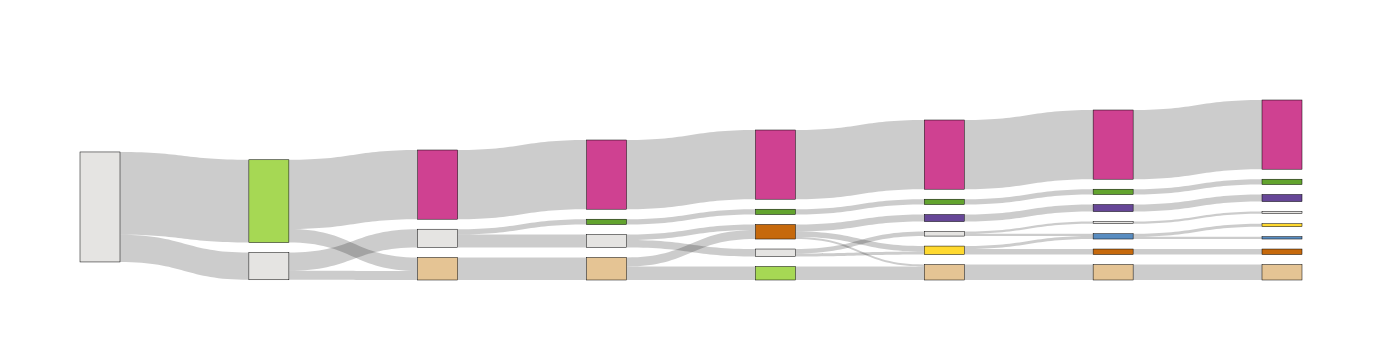

In [26]:
# fig.update_layout(width=2400, height = 600)
fig.show()

In [27]:
patch_list = [mpatches.Patch(facecolor=value, label=key, edgecolor='black', linewidth=0.5) for key, value in prog_label_color_dict.items()]

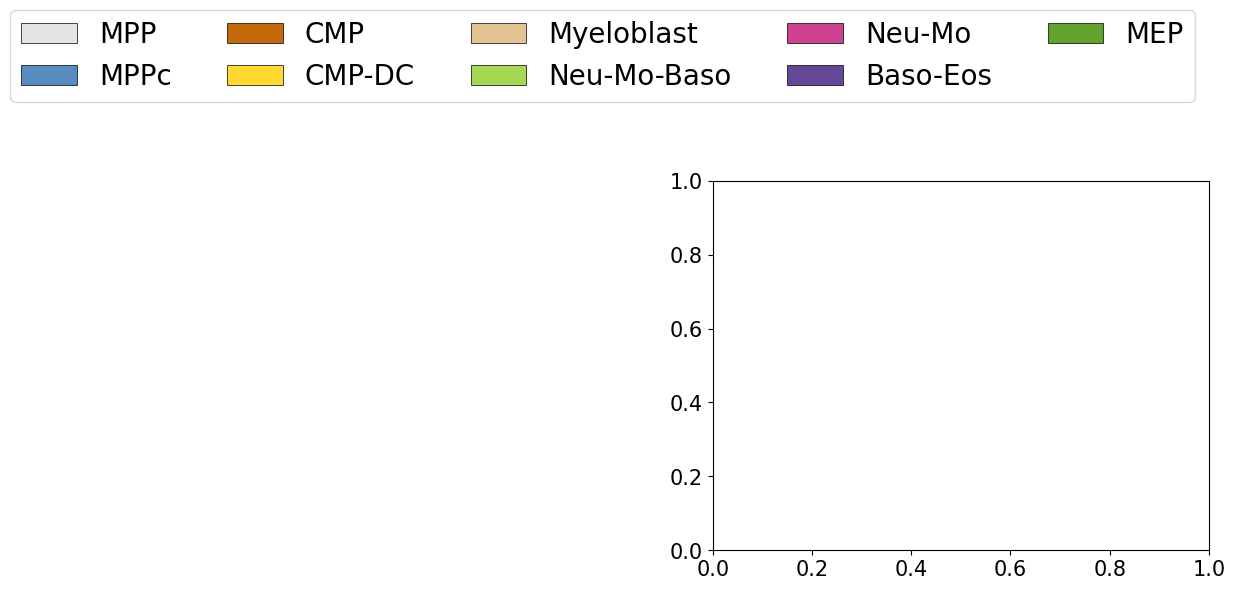

In [29]:
plt.legend(handles=patch_list, ncol=5, bbox_to_anchor=(1, 1.5), fontsize=20)
# plt.tight_layout()

# Figure 5a and S16b,c

In [30]:
invitro_data_dir = '../data/larry/'
df_meta = pd.read_csv(f'{invitro_data_dir}input/stateFate_inVitro_metadata.txt', sep='\t')å

In [32]:
nprogs = 7
df_solx = pd.read_csv(f'../data/larry/results/tree/collapsed_k{nprogs}_t10_tree_assignment.csv', index_col = 0)
df_sola = pd.read_csv(f'../data/larry/results/tree/collapsed_k{nprogs}_t10_tree_prog.csv', index_col = 0)

In [33]:
curr_clone_inverse_indices = []
with open('../data/larry/input/collapsed_clone_type_inverse_indices.txt', 'r') as inp:
    for line in inp:
        curr_clone_inverse_indices.append(int(line.rstrip('\n')))
curr_clone_inverse_indices = np.array(curr_clone_inverse_indices)

In [34]:
ntypes = df_meta['Cell type annotation'].nunique()

In [35]:
cell_type_list = list(df_meta['Cell type annotation'].unique())

In [36]:
cell_type_index_dict = {cell_type: idx for idx, cell_type in enumerate(cell_type_list)}

In [40]:
with open(f'{invitro_data_dir}/input/stateFate_inVitro_clone_matrix.mtx', 'r') as inp:
    flag = 0
    for line in inp:
        if line.startswith('%'):
            continue
        data = line.rstrip('\n').split(' ')
        assert(len(data) == 3)
        if flag == 0:
            nclones = int(data[1])
            orig_clone_type_mat = np.zeros((nclones, ntypes))
            flag = 1
        else:
            cell_idx = int(data[0]) - 1
            clone_idx = int(data[1]) - 1
            cell_type_idx = cell_type_index_dict[df_meta.iloc[cell_idx]['Cell type annotation']]
            orig_clone_type_mat[clone_idx][cell_type_idx] = 1

In [41]:
row_indices = np.where(df_solx.values == 1)[0]
col_indices = np.where(df_solx.values == 1)[1]

In [42]:
collapsed_clone_idx_to_prog = {}
for row_idx, col_idx in list(zip(np.where(df_solx.values == 1)[0], np.where(df_solx.values == 1)[1])):
    collapsed_clone_idx_to_prog[df_solx.index[row_idx]] = int(df_solx.columns[col_idx])

In [43]:
df_orig_clone_type_mat = pd.DataFrame(orig_clone_type_mat, columns=cell_type_list, dtype=int)

In [44]:
prog_label = []
for row_idx, row in df_orig_clone_type_mat.iterrows():
    collapsed_clone_idx = curr_clone_inverse_indices[row_idx]
    if collapsed_clone_idx in collapsed_clone_idx_to_prog.keys():
        prog_label.append(collapsed_clone_idx_to_prog[collapsed_clone_idx])
    else:
        prog_label.append(np.nan)

In [45]:
df_orig_clone_type_mat['prog'] = prog_label

In [46]:
ncells = len(df_meta)

In [48]:
with open(f'{invitro_data_dir}/input/stateFate_inVitro_clone_matrix.mtx', 'r') as inp:
    flag = 0
    for line in inp:
        if line.startswith('%'):
            continue
        data = line.rstrip('\n').split(' ')
        assert(len(data) == 3)
        if flag == 0:
            flag = 1
            fate_pred = np.empty(ncells)
            fate_pred[:] = np.nan
        else:
            cell_idx = int(data[0]) - 1
            clone_idx = int(data[1]) - 1
            fate_pred[cell_idx] = df_orig_clone_type_mat.loc[clone_idx]['prog']
            # if np.isnan(df_orig_clone_type_mat.loc[clone_idx]['prog']):
            # cell_type_idx = cell_type_index_dict[df_meta.iloc[cell_idx]['Cell type annotation']]
            # orig_clone_type_mat[clone_idx][cell_type_idx] = 1

In [49]:
df_meta_fate = df_meta.copy()

In [50]:
df_meta_fate['fate'] = fate_pred

In [51]:
df_meta_fate_collapsed = df_meta_fate.copy()

df_meta_fate_collapsed.loc[df_meta_fate['Cell type annotation'] == 'Ccr7_DC', 'Cell type annotation'] = 'DC'
df_meta_fate_collapsed.loc[df_meta_fate['Cell type annotation'] == 'pDC', 'Cell type annotation'] = 'DC'

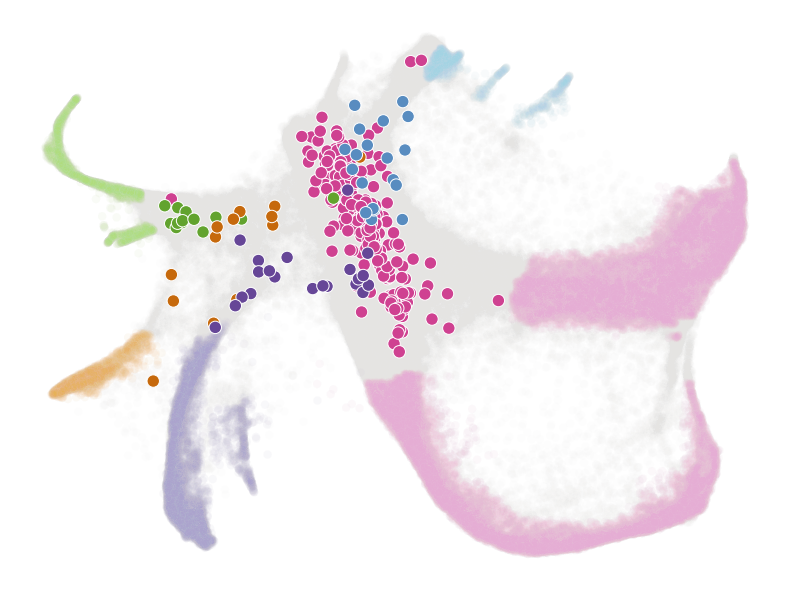

In [52]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
g = sns.scatterplot(data=df_meta_collapsed, x='SPRING-x', y='SPRING-y', alpha=0.05, hue='Cell type annotation',
                    palette={key: '#E5E4E2' for key in my_pallete_collapsed.keys()}, legend=False)

g = sns.scatterplot(data=df_meta_collapsed[df_meta_collapsed['Cell type annotation'].isin(['Monocyte', 'Neutrophil',
                                                                       'Baso', 'Eos', 'Meg', 'Erythroid', 'Mast', 'Lymphoid', 'DC'])],
                    x='SPRING-x', y='SPRING-y', alpha=0.05, hue='Cell type annotation',
                    palette={'Monocyte': sns.color_palette(palette='PiYG')[1],
                             'Neutrophil': sns.color_palette(palette='PiYG')[1],
                             'Baso': sns.color_palette(palette='PuOr')[-2],
                             'Eos': sns.color_palette(palette='PuOr')[-2], 
                             'Meg': sns.color_palette(palette='PiYG')[-2],
                             'Erythroid': sns.color_palette(palette='PiYG')[-2],
                             'Mast': sns.color_palette(palette='PuOr')[1],
                             'Lymphoid': sns.color_palette(palette='RdYlBu')[-2],
                             'DC': sns.color_palette(palette='RdYlBu')[-2],}, legend=False)

# Neu-Mono progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 6) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 2))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PiYG')[0]},
                    alpha=1, legend=False, s=80)

# Meg-Ery progneitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 2) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 2))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PiYG')[-1]},
                    alpha=1, legend=False, s=80)

# Mast progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 3) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 2))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PuOr')[0]},
                    alpha=1, legend=False, s=80)

# Baso-Eos progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 0) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 2))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PuOr')[-1]},
                    alpha=1, legend=False, s=80)

# lymphoid progneitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 5) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 2))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='RdYlBu')[-1]},
                    alpha=1, legend=False, s=80)

ax.tick_params(axis='y',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               left=False,      # ticks along the bottom edge are off
               right=False,         # ticks along the top edge are off
               labelleft=False) # labels along the bottom edge are off
ax.set_ylabel('');

ax.tick_params(axis='x',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               bottom=False,      # ticks along the bottom edge are off
               top=False,         # ticks along the top edge are off
               labelbottom=False) # labels along the bottom edge are off
ax.set_xlabel('');
ax.axis('off');
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_fate_pred_day2.pdf', bbox_inches='tight')

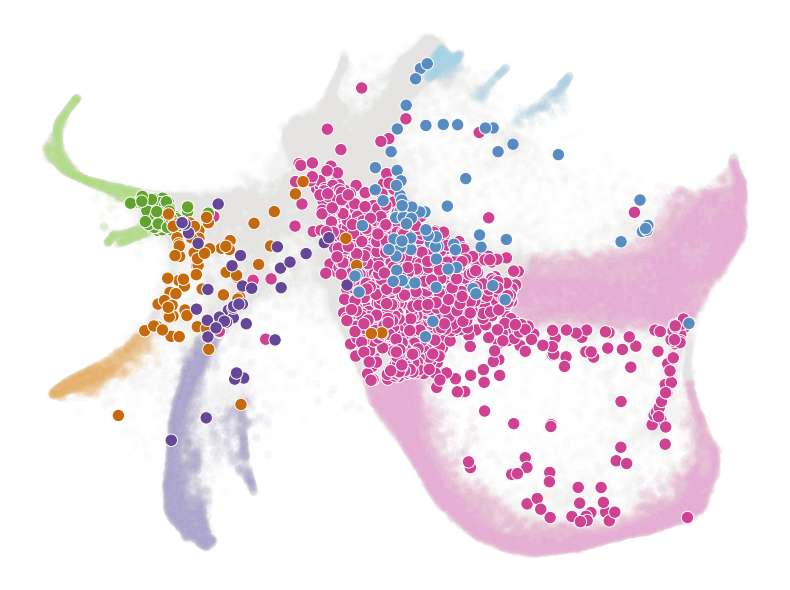

In [53]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
g = sns.scatterplot(data=df_meta_collapsed, x='SPRING-x', y='SPRING-y', alpha=0.05, hue='Cell type annotation',
                    palette={key: '#E5E4E2' for key in my_pallete_collapsed.keys()}, legend=False)

g = sns.scatterplot(data=df_meta_collapsed[df_meta_collapsed['Cell type annotation'].isin(['Monocyte', 'Neutrophil',
                                                                       'Baso', 'Eos', 'Meg', 'Erythroid', 'Mast', 'Lymphoid', 'DC'])],
                    x='SPRING-x', y='SPRING-y', alpha=0.05, hue='Cell type annotation',
                    palette={'Monocyte': sns.color_palette(palette='PiYG')[1],
                             'Neutrophil': sns.color_palette(palette='PiYG')[1],
                             'Baso': sns.color_palette(palette='PuOr')[-2],
                             'Eos': sns.color_palette(palette='PuOr')[-2], 
                             'Meg': sns.color_palette(palette='PiYG')[-2],
                             'Erythroid': sns.color_palette(palette='PiYG')[-2],
                             'Mast': sns.color_palette(palette='PuOr')[1],
                             'Lymphoid': sns.color_palette(palette='RdYlBu')[-2],
                             'DC': sns.color_palette(palette='RdYlBu')[-2],}, legend=False)

# Neu-Mono progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 6) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 4))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PiYG')[0]},
                    alpha=1, legend=False, s=80)

# Meg-Ery progneitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 2) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 4))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PiYG')[-1]},
                    alpha=1, legend=False, s=80)

# Mast progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 3) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 4))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PuOr')[0]},
                    alpha=1, legend=False, s=80)

# Baso-Eos progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 0) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 4))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PuOr')[-1]},
                    alpha=1, legend=False, s=80)

# lymphoid progneitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 5) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 4))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='RdYlBu')[-1]},
                    alpha=1, legend=False, s=80)

ax.tick_params(axis='y',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               left=False,      # ticks along the bottom edge are off
               right=False,         # ticks along the top edge are off
               labelleft=False) # labels along the bottom edge are off
ax.set_ylabel('');

ax.tick_params(axis='x',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               bottom=False,      # ticks along the bottom edge are off
               top=False,         # ticks along the top edge are off
               labelbottom=False) # labels along the bottom edge are off
ax.set_xlabel('');
ax.axis('off');
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_fate_pred_day2.pdf', bbox_inches='tight')

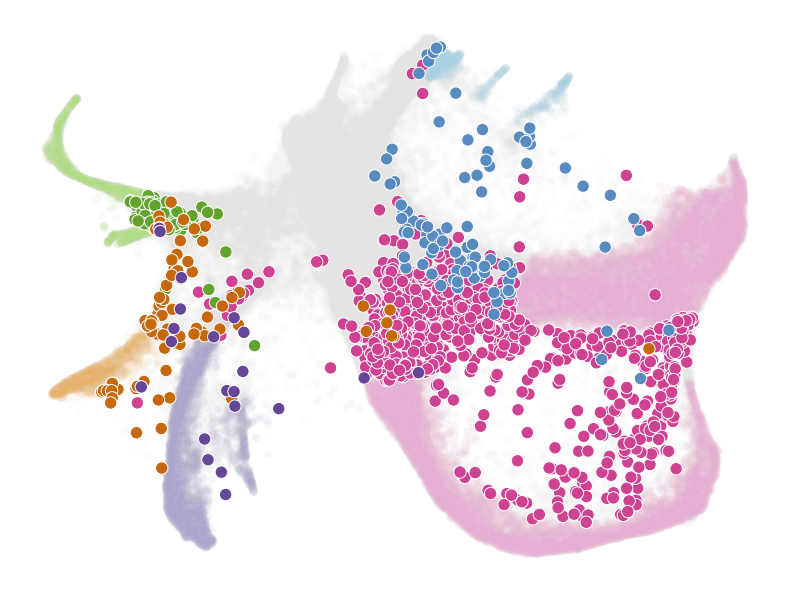

In [54]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
g = sns.scatterplot(data=df_meta_collapsed, x='SPRING-x', y='SPRING-y', alpha=0.05, hue='Cell type annotation',
                    palette={key: '#E5E4E2' for key in my_pallete_collapsed.keys()}, legend=False)

g = sns.scatterplot(data=df_meta_collapsed[df_meta_collapsed['Cell type annotation'].isin(['Monocyte', 'Neutrophil',
                                                                       'Baso', 'Eos', 'Meg', 'Erythroid', 'Mast', 'Lymphoid', 'DC'])],
                    x='SPRING-x', y='SPRING-y', alpha=0.05, hue='Cell type annotation',
                    palette={'Monocyte': sns.color_palette(palette='PiYG')[1],
                             'Neutrophil': sns.color_palette(palette='PiYG')[1],
                             'Baso': sns.color_palette(palette='PuOr')[-2],
                             'Eos': sns.color_palette(palette='PuOr')[-2], 
                             'Meg': sns.color_palette(palette='PiYG')[-2],
                             'Erythroid': sns.color_palette(palette='PiYG')[-2],
                             'Mast': sns.color_palette(palette='PuOr')[1],
                             'Lymphoid': sns.color_palette(palette='RdYlBu')[-2],
                             'DC': sns.color_palette(palette='RdYlBu')[-2],}, legend=False)

# Neu-Mono progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 6) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 6))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PiYG')[0]},
                    alpha=1, legend=False, s=80)

# Meg-Ery progneitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 2) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 6))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PiYG')[-1]},
                    alpha=1, legend=False, s=80)

# Mast progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 3) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 6))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PuOr')[0]},
                    alpha=1, legend=False, s=80)

# Baso-Eos progenitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 0) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 6))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='PuOr')[-1]},
                    alpha=1, legend=False, s=80)

# lymphoid progneitor
g = sns.scatterplot(data=df_meta_fate_collapsed[((df_meta_fate_collapsed['fate'] == 5) & (df_meta_fate_collapsed['Cell type annotation'] == 'Undifferentiated')
                                       & (df_meta_fate_collapsed['Time point'] == 6))],
                    x='SPRING-x', y='SPRING-y',
                    hue = 'Cell type annotation', palette={'Undifferentiated': sns.color_palette(palette='RdYlBu')[-1]},
                    alpha=1, legend=False, s=80)

ax.tick_params(axis='y',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               left=False,      # ticks along the bottom edge are off
               right=False,         # ticks along the top edge are off
               labelleft=False) # labels along the bottom edge are off
ax.set_ylabel('');

ax.tick_params(axis='x',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               bottom=False,      # ticks along the bottom edge are off
               top=False,         # ticks along the top edge are off
               labelbottom=False) # labels along the bottom edge are off
ax.set_xlabel('');
ax.axis('off');
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_fate_pred_day2.pdf', bbox_inches='tight')

# Figure 5b,c

In [55]:
df_pc = pd.read_csv('../data/larry/full_LARRY_PCA.csv', index_col = 0) #file not included due to size

In [68]:
diff_cell_type_list = list(df_meta_fate_collapsed['Cell type annotation'].unique()[1:])

In [57]:
diff_cell_type_list

['Monocyte',
 'Neutrophil',
 'Baso',
 'Mast',
 'Erythroid',
 'Meg',
 'DC',
 'Lymphoid',
 'Eos']

In [58]:
cell_type_centroids = np.zeros((len(diff_cell_type_list), 50))

In [59]:
for cell_type_idx, cell_type in enumerate(diff_cell_type_list):
    cell_type_centroids[cell_type_idx, :] = df_pc.loc[df_meta_collapsed[df_meta_collapsed['Cell type annotation'] == cell_type]['Cell barcode']].mean(axis=0)

In [60]:
np.argmin(cdist(df_pc.values, cell_type_centroids), axis=1)

array([1, 2, 0, ..., 0, 0, 7])

In [61]:
pc_fate = pd.Series(np.argmin(cdist(df_pc.values, cell_type_centroids), axis=1)).apply(lambda x: diff_cell_type_list[x])

In [62]:
df_meta_collapsed_pc_fate = df_meta_collapsed.copy()
df_meta_collapsed_pc_fate['pc_fate'] = pc_fate

In [63]:
df_meta_combined = df_meta_collapsed_pc_fate.copy()

In [64]:
df_meta_combined['fate'] = df_meta_fate_collapsed['fate']

In [65]:
df_meta_combined

Library       Cell barcode  Time point Starting population  \
0           d6_2_2  GCGTGCAA-AGAAGTTA         6.0       Lin-Kit+Sca1-   
1           d6_2_2  AAGGGACC-CTCGATGC         6.0       Lin-Kit+Sca1-   
2           d6_2_2  CGTACCGA-AGCGCCTT         6.0       Lin-Kit+Sca1-   
3           d6_2_2  CTGAAGGG-AGGAGCTT         6.0       Lin-Kit+Sca1-   
4           d6_2_2  CCGTAGCT-AGGCAGTT         6.0       Lin-Kit+Sca1-   
...            ...                ...         ...                 ...   
130882  LSK_d6_1_3  TCTGATTT-CGGGCTTT         6.0       Lin-Kit+Sca1+   
130883  LSK_d6_1_3  AGTCACAA-TGTGTCCT         6.0       Lin-Kit+Sca1+   
130884  LSK_d6_1_3  GGAGGTTT-AGGCAGTT         6.0       Lin-Kit+Sca1+   
130885  LSK_d6_1_3  CCGGAAAT-GGGAAGGT         6.0       Lin-Kit+Sca1+   
130886  LSK_d6_1_3  GTATTGAC-GGGTGTAT         6.0       Lin-Kit+Sca1+   

       Cell type annotation  Well  SPRING-x  SPRING-y     pc_fate  fate  
0          Undifferentiated     2   411.496   -96.190  Neutrophil   NaN  
1          Undifferentiated     2  -587.462  -306.925        Baso   NaN  
2                  Monocyte     2  1429.805  -429.300    Monocyte   6.0  
3                Neutrophil     2  1150.028 -2030.369  Neutrophil   NaN  
4          Undifferentiated     2 -1169.594   362.010  Neutrophil   3.0  
...                     ...   ...       ...       ...         ...   ...  
130882     Undifferentiated     1  -308.468  -163.223    Monocyte   NaN  
130883     Undifferentiated     1    -3.435   575.133    Lymphoid   NaN  
130884             Monocyte     1  2548.309    24.683    Monocyte   NaN  
130885             Monocyte     1  2658.601   131.098    Monocyte   NaN  
130886     Undifferentiated     1  -266.344   996.297    Lymphoid   NaN  

[130887 rows x 10 columns]

In [66]:
df_prog = df_sola.copy()

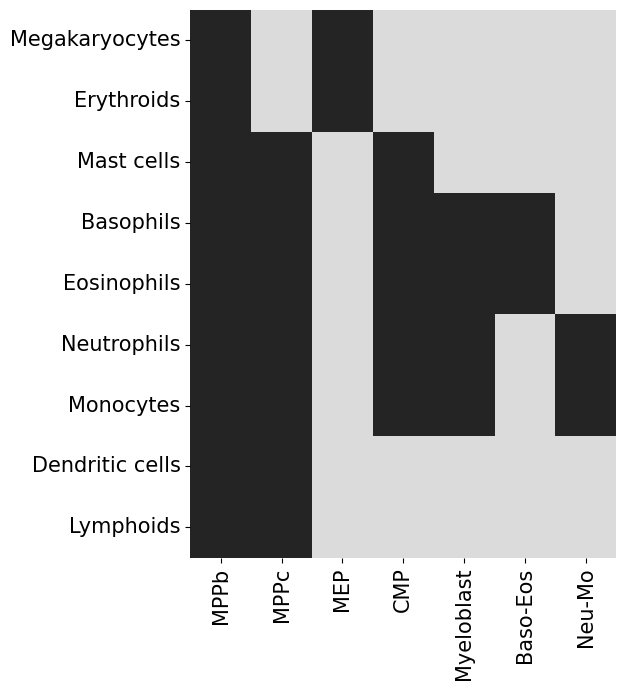

In [67]:
df_prog_ordered = df_prog.reindex(index=[1,5,2,3,4,0,6],
                                  columns=['Meg', 'Erythroid', 'Mast', 'Baso', 'Eos', 'Neutrophil', 'Monocyte', 'DC' , 'Lymphoid'])

fig, ax = plt.subplots(1,1,figsize=(9,7))
sns.heatmap(df_prog_ordered.T, square=True, annot=False, cbar=False, cmap=sns.color_palette('binary'))
plt.gca().set_yticklabels(['Megakaryocytes', 'Erythroids', 'Mast cells', 'Basophils', 'Eosinophils',
                           'Neutrophils', 'Monocytes', 'Dendritic cells', 'Lymphoids']);
plt.gca().set_xticklabels(['MPPb', 'MPPc', 'MEP', 'CMP', 'Myeloblast', 'Baso-Eos', 'Neu-Mo'], rotation=90);
plt.gca().set_ylabel('');
plt.gca().set_xlabel('');

plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/prog_mat_t.png', bbox_inches='tight', dpi=300)

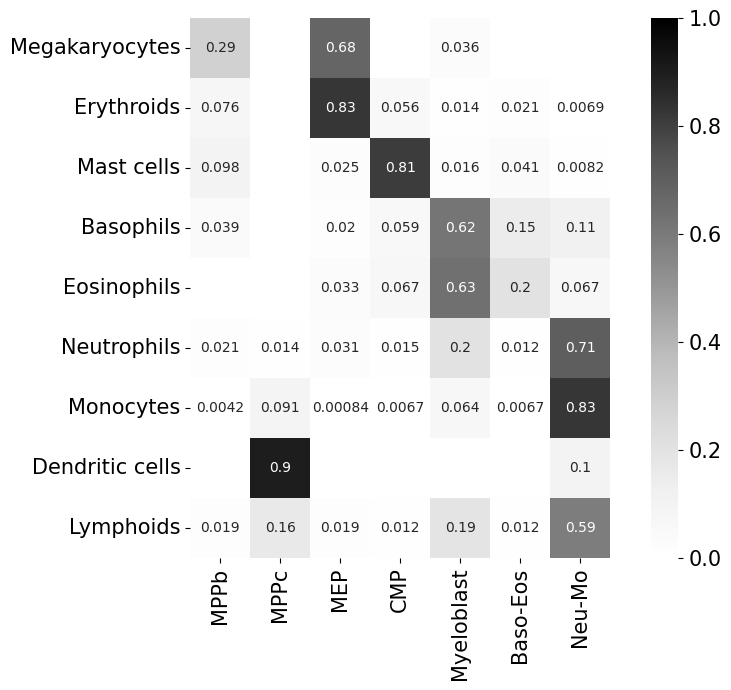

In [69]:
df_selected = df_meta_combined[((df_meta_combined['Cell type annotation'] == 'Undifferentiated'))]

df_confusion = df_selected.groupby(['fate', 'pc_fate']).size().to_frame().reset_index().pivot(index='fate', columns='pc_fate', values=0).fillna(0)

df_confusion_norm = df_confusion.div(df_confusion.sum(axis=0),axis=1)

df_confusion_norm = df_confusion_norm.reindex(index=[1,5,2,3,4,0,6],
                                              columns=['Meg', 'Erythroid', 'Mast', 'Baso', 'Eos', 'Neutrophil', 'Monocyte', 'DC' , 'Lymphoid'])

fig, ax = plt.subplots(1,1,figsize=(9,7))
sns.heatmap(df_confusion_norm.T, square=True, annot=True, cmap=sns.color_palette("Greys", as_cmap=True), mask = df_confusion_norm.T == 0, vmin=0, vmax=1)
plt.gca().set_yticklabels(['Megakaryocytes', 'Erythroids', 'Mast cells', 'Basophils', 'Eosinophils',
                           'Neutrophils', 'Monocytes', 'Dendritic cells', 'Lymphoids'], rotation=0);
plt.gca().set_xticklabels(['MPPb', 'MPPc', 'MEP', 'CMP', 'Myeloblast', 'Baso-Eos', 'Neu-Mo'], rotation=90);
plt.gca().set_ylabel('');
plt.gca().set_xlabel('');

plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/prog_pred_t.png', bbox_inches='tight', dpi = 300)

# Figure S1 (Baso-Eos subsampling)

## Generate inputs

In [ ]:
# subsampled_celltype = 'Eos'
# subsampled_celltype = 'Baso'
subsampled_celltype = 'Erythroid'
# subsampling_prob = 0.5

df_meta = pd.read_csv('../data/larry/input/stateFate_inVitro_metadata.txt', sep='\t')
ntypes = df_meta['Cell type annotation'].nunique()
cell_type_list = list(df_meta['Cell type annotation'].unique())
cell_type_index_dict = {cell_type: idx for idx, cell_type in enumerate(cell_type_list)}

for subsampling_prob in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]:
# for subsampling_prob in [0.1, 0.05, 0.01]:
# for subsampling_prob in [0.95]:
    for iter_idx in range(5):

        np.random.seed(iter_idx)
        
        with open(f'../data/larry/input/stateFate_inVitro_clone_matrix.mtx', 'r') as inp:
            flag = 0
            for line in inp:
                if line.startswith('%'):
                    continue
                data = line.rstrip('\n').split(' ')
                assert(len(data) == 3)
                if flag == 0:
                    nclones = int(data[1])
                    subsampled_clone_type_mat = np.zeros((nclones, ntypes))
                    flag = 1
                else:
                    cell_idx = int(data[0]) - 1
                    clone_idx = int(data[1]) - 1
                    curr_celltype = df_meta.iloc[cell_idx]['Cell type annotation']
                    cell_type_idx = cell_type_index_dict[curr_celltype]
                    if curr_celltype == subsampled_celltype:
                        if np.random.rand() <= subsampling_prob:
                            subsampled_clone_type_mat[clone_idx][cell_type_idx] = 1
                    else:
                        subsampled_clone_type_mat[clone_idx][cell_type_idx] = 1

        df_subsampled_clone_type_mat = pd.DataFrame(subsampled_clone_type_mat, columns = cell_type_list, dtype=int)
        df_subsampled_clone_type_mat['DC'] = df_subsampled_clone_type_mat['Ccr7_DC'] | df_subsampled_clone_type_mat['pDC']
        df_subsampled_clone_type_mat = df_subsampled_clone_type_mat.drop(['Ccr7_DC', 'pDC'], axis=1)
        
        deduplicated_subsampled_clone_type_mat, subsampled_clone_type_inverse_indices, subsampled_clone_counts = np.unique(df_subsampled_clone_type_mat.values,
                                                                                                                axis=0,
                                                                                                                return_inverse=True,
                                                                                                                return_counts=True)

        df_deduplicated_subsampled_clone_type_mat = pd.DataFrame(deduplicated_subsampled_clone_type_mat,
                                                                columns = df_subsampled_clone_type_mat.columns,
                                                                dtype = int)

        df_deduplicated_subsampled_clone_type_mat['counts'] = subsampled_clone_counts
        
        # df_deduplicated_subsampled_clone_type_mat.to_csv(f'../data/larry/results/bootstrap/subsampling/input/subsampled_{subsampled_celltype}_{subsampling_prob}_{iter_idx}_clone_type_mat.csv')

        # with open(f'../data/larry/results/bootstrap/subsampling/input/subsampled_{subsampled_celltype}_{subsampling_prob}_{iter_idx}_clone_type_inverse_indices.txt', 'w') as out:
        #     for idx in subsampled_clone_type_inverse_indices:
        #         out.write(f'{idx}\n')

        nclones_with_subsampled_celltype = df_deduplicated_subsampled_clone_type_mat[df_deduplicated_subsampled_clone_type_mat[subsampled_celltype] == 1]['counts'].sum()
        # print(f'{subsampling_prob}\t{iter_idx}\t{nclones_with_subsampled_celltype}')

## Get statistics

In [ ]:
# subsampled_celltype = 'Eos'
subsampled_celltype = 'Baso'
# subsampled_celltype = 'Erythroid'
# subsampling_prob = 0.5

df_meta = pd.read_csv('../data/larry/input/stateFate_inVitro_metadata.txt', sep='\t')
ntypes = df_meta['Cell type annotation'].nunique()
cell_type_list = list(df_meta['Cell type annotation'].unique())
cell_type_index_dict = {cell_type: idx for idx, cell_type in enumerate(cell_type_list)}

subsampling_stat_data = []

# for subsampling_prob in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]:
for subsampling_prob in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]:
# for subsampling_prob in [0.95]:
    for iter_idx in range(5):

        np.random.seed(iter_idx)
        
        with open(f'../data/larry/input/stateFate_inVitro_clone_matrix.mtx', 'r') as inp:
            flag = 0
            for line in inp:
                if line.startswith('%'):
                    continue
                data = line.rstrip('\n').split(' ')
                assert(len(data) == 3)
                if flag == 0:
                    nclones = int(data[1])
                    subsampled_clone_type_mat = np.zeros((nclones, ntypes))
                    flag = 1
                else:
                    cell_idx = int(data[0]) - 1
                    clone_idx = int(data[1]) - 1
                    curr_celltype = df_meta.iloc[cell_idx]['Cell type annotation']
                    cell_type_idx = cell_type_index_dict[curr_celltype]
                    if curr_celltype == subsampled_celltype:
                        if np.random.rand() <= subsampling_prob:
                            subsampled_clone_type_mat[clone_idx][cell_type_idx] = 1
                    else:
                        subsampled_clone_type_mat[clone_idx][cell_type_idx] = 1
        
        df_subsampled_clone_type_mat = pd.DataFrame(subsampled_clone_type_mat, columns = cell_type_list, dtype=int)
        df_subsampled_clone_type_mat['DC'] = df_subsampled_clone_type_mat['Ccr7_DC'] | df_subsampled_clone_type_mat['pDC']
        df_subsampled_clone_type_mat = df_subsampled_clone_type_mat.drop(['Ccr7_DC', 'pDC'], axis=1)

        # subsmapling_stat_dict = df_subsampled_clone_type_mat.sum(axis=0).to_dict()
        # subsampling_stat_dict['prob'] = subsampling_prob
        # subsampling_stat_dict['iter'] = iter_idx
        # subsampling_stat_data.append(subsampling_stat_dict)
        
        deduplicated_subsampled_clone_type_mat, subsampled_clone_type_inverse_indices, subsampled_clone_counts = np.unique(df_subsampled_clone_type_mat.values,
                                                                                                                axis=0,
                                                                                                                return_inverse=True,
                                                                                                                return_counts=True)

        df_deduplicated_subsampled_clone_type_mat = pd.DataFrame(deduplicated_subsampled_clone_type_mat,
                                                                columns = df_subsampled_clone_type_mat.columns,
                                                                dtype = int)

        df_deduplicated_subsampled_clone_type_mat['counts'] = subsampled_clone_counts
    

        nclones_with_subsampled_celltype = df_deduplicated_subsampled_clone_type_mat[df_deduplicated_subsampled_clone_type_mat[subsampled_celltype] == 1]['counts'].sum()
        # print(f'{subsampling_prob}\t{iter_idx}\t{nclones_with_subsampled_celltype}')
        subsampling_stat_data.append([subsampling_prob, iter_idx, nclones_with_subsampled_celltype])

df_subsampling_stat = pd.DataFrame(subsampling_stat_data, columns = ['prob', 'iter', 'nclones'])
# df_subsampling_stat.to_csv(f'../data/larry/results/bootstrap/subsampling/{subsampled_celltype}_stat.csv')

## Eos subsampling

In [122]:
# subsampling_data = []

# for nprogs in range(1, 11):
#     for subsampling_prob in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
#         for iter in range(5):
#             df_subsample_sola = pd.read_csv(f'../data/larry/results/bootstrap/subsampling/results/Eos/k{nprogs}_p{subsampling_prob}_i{iter}_t10_tree_prog.csv', index_col=0)
#             flag = 0
#             for prog in df_subsample_sola.values:
#                 if np.array_equal(prog,np.array([0, 0, 1, 0, 0, 0, 0, 1, 0])):
#                     flag = 1
#                     break
#             subsampling_data.append([nprogs, subsampling_prob, iter, flag])    

# df_subsampling = pd.DataFrame(subsampling_data, columns = ['nprogs', 'prob', 'iter', 'present'])

In [125]:
# df_subsampling.to_csv("../data/larry/results/bootstrap/subsampling/Eos_subsampling.csv")

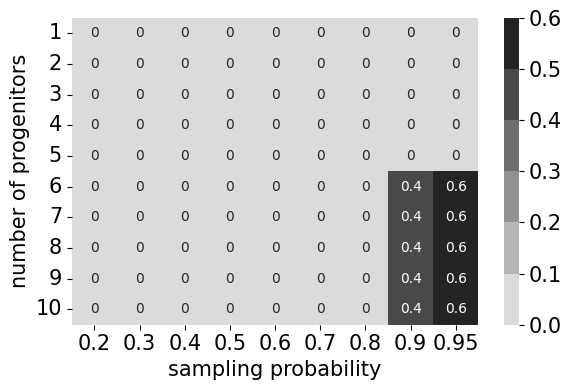

In [136]:
df_subsampling = pd.read_csv("../data/larry/results/bootstrap/subsampling/Eos_subsampling.csv")

df_subsampling_viz = df_subsampling.groupby(['nprogs', 'prob']).mean().reset_index().pivot(index='nprogs', columns='prob', values='present')

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.heatmap(data = df_subsampling_viz, annot=True, cmap=sns.color_palette('binary'))

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('number of progenitors', fontsize=15);

plt.gca().set_yticklabels(list(range(1,11)), rotation=0)
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_eos_subsampling.pdf', bbox_inches='tight')

In [127]:
df_subsampling_stat = pd.read_csv('../data/larry/results/bootstrap/subsampling/Eos_stat.csv')

In [128]:
df_subsampling_stat.groupby('prob').median()

Unnamed: 0  iter  nclones
prob                           
0.2         37.0   2.0     27.0
0.3         32.0   2.0     34.0
0.4         27.0   2.0     40.0
0.5         22.0   2.0     49.0
0.6         17.0   2.0     59.0
0.7         12.0   2.0     67.0
0.8          7.0   2.0     75.0
0.9          2.0   2.0     82.0

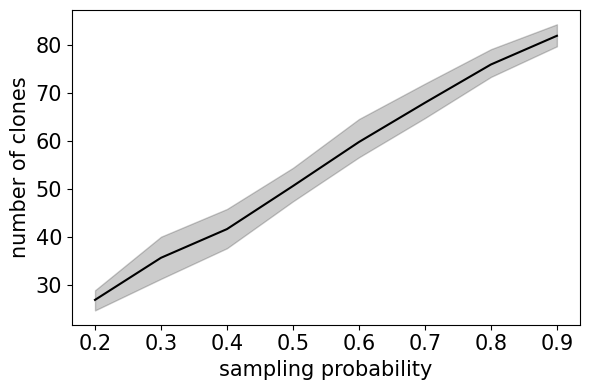

In [129]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data = df_subsampling_stat, x = 'prob', y='nclones', color='black')

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('number of clones', fontsize=15);

plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# plt.xticks([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2])
# plt.gca().set_xticklabels(['25 X 25', '50 X 50', '100 X 100'], fontsize=20)
# plt.gca().set_xticklabels(['25 X 25', '50 X 50'], fontsize=20)
# plt.legend(title=r'k', loc='lower left')
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_subsampling_eos_stat.pdf', bbox_inches='tight')

## Baso subsampling

In [130]:
# subsampling_data = []

# for nprogs in range(1, 11):
#     for subsampling_prob in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#         for iter in range(5):
#             df_subsample_sola = pd.read_csv(f'../data/larry/results/bootstrap/subsampling/results/Baso/k{nprogs}_p{subsampling_prob}_i{iter}_t10_tree_prog.csv', index_col=0)
#             flag = 0
#             for prog in df_subsample_sola.values:
#                 if np.array_equal(prog,np.array([0, 0, 1, 0, 0, 0, 0, 1, 0])):
#                     flag = 1
#                     break
#             subsampling_data.append([nprogs, subsampling_prob, iter, flag])    

# df_subsampling = pd.DataFrame(subsampling_data, columns = ['nprogs', 'prob', 'iter', 'present'])

In [131]:
# df_subsampling.to_csv("../data/larry/results/bootstrap/subsampling/Baso_subsampling.csv")

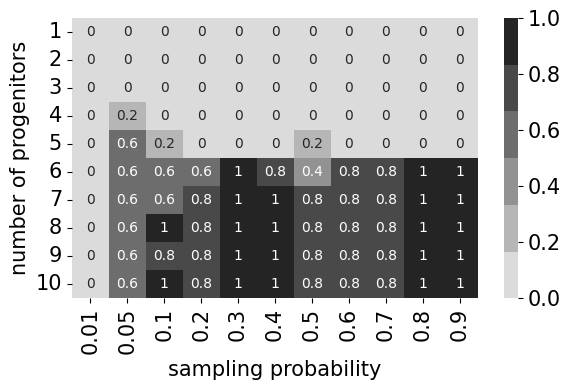

In [132]:
df_subsampling = pd.read_csv("../data/larry/results/bootstrap/subsampling/Baso_subsampling.csv")

df_subsampling_viz = df_subsampling.groupby(['nprogs', 'prob']).mean().reset_index().pivot(index='nprogs', columns='prob', values='present')

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.heatmap(data = df_subsampling_viz, annot=True, cmap=sns.color_palette('binary'))

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('number of progenitors', fontsize=15);

plt.gca().set_yticklabels(list(range(1,11)), rotation=0)
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_baso_subsampling.pdf', bbox_inches='tight')

In [133]:
df_subsampling_stat = pd.read_csv('../data/larry/results/bootstrap/subsampling/Baso_stat.csv')

In [134]:
df_subsampling_stat.groupby('prob').median()

Unnamed: 0  iter  nclones
prob                           
0.01        52.0   2.0     49.0
0.05        47.0   2.0    182.0
0.10        42.0   2.0    286.0
0.20        37.0   2.0    412.0
0.30        32.0   2.0    483.0
0.40        27.0   2.0    540.0
0.50        22.0   2.0    575.0
0.60        17.0   2.0    613.0
0.70        12.0   2.0    637.0
0.80         7.0   2.0    652.0
0.90         2.0   2.0    669.0

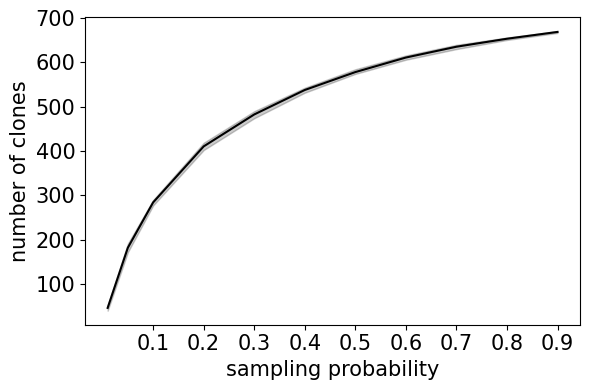

In [135]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data = df_subsampling_stat, x = 'prob', y='nclones', color='black')

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('number of clones', fontsize=15);

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# plt.xticks([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2])
# plt.gca().set_xticklabels(['25 X 25', '50 X 50', '100 X 100'], fontsize=20)
# plt.gca().set_xticklabels(['25 X 25', '50 X 50'], fontsize=20)
# plt.legend(title=r'k', loc='lower left')
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_subsampling_baso_stat.pdf', bbox_inches='tight')

# Figure S2c,d (stability)

## Generate inputs

In [ ]:
df_meta = pd.read_csv('../data/larry/input/stateFate_inVitro_metadata.txt', sep='\t')
ntypes = df_meta['Cell type annotation'].nunique()
cell_type_list = list(df_meta['Cell type annotation'].unique())
cell_type_index_dict = {cell_type: idx for idx, cell_type in enumerate(cell_type_list)}

for subsampling_prob in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]:
# for subsampling_prob in [0.1, 0.05, 0.01]:
# for subsampling_prob in [0.95]:
    for iter_idx in range(5):

        np.random.seed(iter_idx)
        
        with open(f'../data/larry/input/stateFate_inVitro_clone_matrix.mtx', 'r') as inp:
            flag = 0
            for line in inp:
                if line.startswith('%'):
                    continue
                data = line.rstrip('\n').split(' ')
                assert(len(data) == 3)
                if flag == 0:
                    nclones = int(data[1])
                    subsampled_clone_type_mat = np.zeros((nclones, ntypes))
                    flag = 1
                else:
                    cell_idx = int(data[0]) - 1
                    clone_idx = int(data[1]) - 1
                    curr_celltype = df_meta.iloc[cell_idx]['Cell type annotation']
                    cell_type_idx = cell_type_index_dict[curr_celltype]
                    # if np.random.rand() <= subsampling_prob:
                        subsampled_clone_type_mat[clone_idx][cell_type_idx] = 1

        df_subsampled_clone_type_mat = pd.DataFrame(subsampled_clone_type_mat, columns = cell_type_list, dtype=int)
        df_subsampled_clone_type_mat['DC'] = df_subsampled_clone_type_mat['Ccr7_DC'] | df_subsampled_clone_type_mat['pDC']
        df_subsampled_clone_type_mat = df_subsampled_clone_type_mat.drop(['Ccr7_DC', 'pDC'], axis=1)
        
        deduplicated_subsampled_clone_type_mat, subsampled_clone_type_inverse_indices, subsampled_clone_counts = np.unique(df_subsampled_clone_type_mat.values,
                                                                                                                axis=0,
                                                                                                                return_inverse=True,
                                                                                                                return_counts=True)

        df_deduplicated_subsampled_clone_type_mat = pd.DataFrame(deduplicated_subsampled_clone_type_mat,
                                                                columns = df_subsampled_clone_type_mat.columns,
                                                                dtype = int)

        df_deduplicated_subsampled_clone_type_mat['counts'] = subsampled_clone_counts
        
        # df_deduplicated_subsampled_clone_type_mat.to_csv(f'../data/larry/results/bootstrap/stability/input/stability_{subsampling_prob}_{iter_idx}_clone_type_mat.csv')

        # with open(f'../data/larry/results/bootstrap/stability/input/stability_{subsampling_prob}_{iter_idx}_clone_type_inverse_indices.txt', 'w') as out:
        #     for idx in subsampled_clone_type_inverse_indices:
        #         out.write(f'{idx}\n')

        nclones_with_subsampled_celltype = df_deduplicated_subsampled_clone_type_mat[df_deduplicated_subsampled_clone_type_mat['Neutrophil'] == 1]['counts'].sum()
        # print(f'{subsampling_prob}\t{iter_idx}\t{nclones_with_subsampled_celltype}')

## jac similarity

In [144]:
# stability_jac_data = []

# for nprogs in range(1, 11):

#     df_sola = pd.read_csv(f'../data/larry/results/tree/collapsed_k{nprogs}_t10_tree_prog.csv', index_col = 0)
#     gt_prog_set = set([tuple(row) for row in df_sola.values])
    
#     for subsampling_prob in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#         for iter in range(5):
#             df_stability_sola = pd.read_csv(f'../data/larry/results/bootstrap/stability/results/k{nprogs}_p{subsampling_prob}_i{iter}_t10_tree_prog.csv', index_col=0)

#             query_prog_set = set([tuple(row) for row in df_stability_sola.values])
#             # jac_dist = jaccard(gt_prog_set, query_prog_set)
#             jac_dist = len(gt_prog_set.intersection(query_prog_set)) / len(gt_prog_set.union(query_prog_set))
            
#             stability_jac_data.append([nprogs, subsampling_prob, iter, jac_dist])

# df_stability_jac = pd.DataFrame(stability_jac_data, columns = ['nprogs', 'prob', 'iter', 'jac'])

# df_stability_jac['jac'] = 1 - df_stability_jac['jac']

# df_stability_jac.to_csv("../data/larry/results/bootstrap/stability/jac_similarity.csv")

In [146]:
df_stability_jac = pd.read_csv("../data/larry/results/bootstrap/stability/jac_similarity.csv", index_col = 0)

In [147]:
df_stability_jac[df_stability_jac['nprogs'] == 7].groupby('prob').median()

nprogs  iter       jac
prob                        
0.2      7.0   2.0  0.900000
0.3      7.0   2.0  0.800000
0.4      7.0   2.0  0.800000
0.5      7.0   2.0  0.700000
0.6      7.0   2.0  0.555556
0.7      7.0   2.0  0.727273
0.8      7.0   2.0  0.600000
0.9      7.0   2.0  0.444444

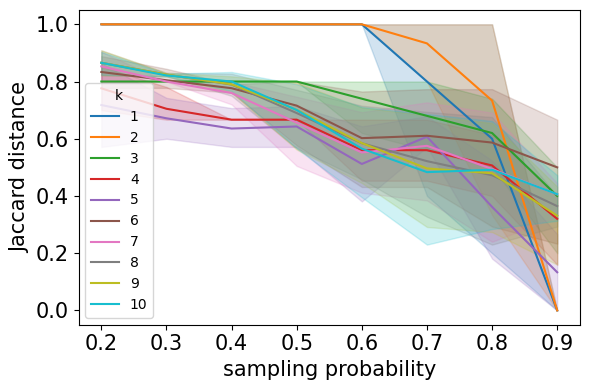

In [148]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data = df_stability_jac, x = 'prob', y='jac', hue= 'nprogs', palette=sns.color_palette())

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('Jaccard distance', fontsize=15);

plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# plt.gca().set_xticklabels(['25 X 25', '50 X 50', '100 X 100'], fontsize=20)
# plt.gca().set_xticklabels(['25 X 25', '50 X 50'], fontsize=20)
plt.legend(title=r'k', loc='lower left')
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_stability_jaccard.pdf', bbox_inches='tight')

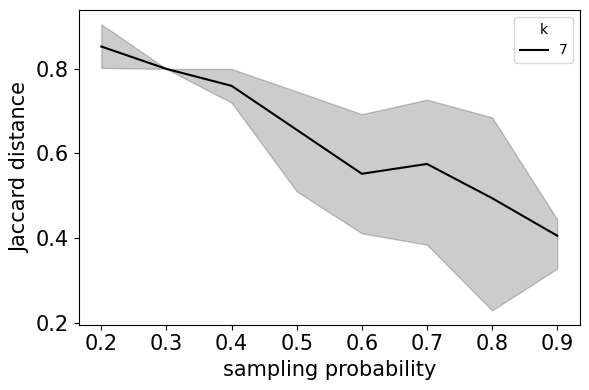

In [149]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data = df_stability_jac[df_stability_jac['nprogs'] == 7],
             x = 'prob', y='jac', hue= 'nprogs', palette=['black'])

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('Jaccard distance', fontsize=15);

plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# plt.gca().set_xticklabels(['25 X 25', '50 X 50', '100 X 100'], fontsize=20)
# plt.gca().set_xticklabels(['25 X 25', '50 X 50'], fontsize=20)
plt.legend(title=r'k', loc='upper right')
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_stability_jaccard_k7.pdf', bbox_inches='tight')

## potency similarity

In [151]:
# stability_potency_data = []

# df_clone_type_mat = pd.read_csv('../data/larry/input/collapsed_clone_type_mat.csv', index_col = 0)
# df_clone_type_mat = df_clone_type_mat[df_clone_type_mat['counts'] >= 10]
# df_clone_type_mat = df_clone_type_mat[df_clone_type_mat.values[:,1:-1].sum(axis=1) > 1]
# df_clone_type_mat = df_clone_type_mat.drop('Undifferentiated', axis=1)

# scaling_factor = df_clone_type_mat['counts'].sum() * (df_clone_type_mat.shape[1] - 1)

# for nprogs in range(1, 11):

#     df_gt_potency = pd.read_csv(f'../data/larry/results/tree/collapsed_k{nprogs}_t10_tree_labeling.csv', index_col = 0)
    
#     for subsampling_prob in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#         for iter in range(5):
#             df_stability_sola = pd.read_csv(f'../data/larry/results/bootstrap/stability/results/k{nprogs}_p{subsampling_prob}_i{iter}_t10_tree_prog.csv', index_col=0)
#             df_stability_sola = df_stability_sola.loc[df_stability_sola.sum(axis=1).sort_values(ascending=False).index]

#             query_potency_data = []
#             for row_iter, row in df_clone_type_mat.iterrows():
#                 flag = 0
#                 for prog_idx in df_stability_sola.index[::-1]:
#                     prog_vector = df_stability_sola.loc[prog_idx]
#                     if np.sum((prog_vector - row[:-1]) == -1) == 0:
#                         query_potency_data.append(list(prog_vector.values))
#                         flag = 1
#                         break
#                 if flag == 0:
#                     query_potency_data.append([1]*(df_clone_type_mat.shape[1] - 1))
                
#                 # assert(flag == 1)    

#             df_query_potency = pd.DataFrame(query_potency_data, columns = df_clone_type_mat.columns[:-1], index = df_clone_type_mat.index)
            
#             potency_diff = np.sum(np.abs(df_query_potency - df_gt_potency).values * df_clone_type_mat['counts'].values[:,np.newaxis]) / scaling_factor

#             stability_potency_data.append([nprogs, subsampling_prob, iter, potency_diff])
            
#             # query_prog_set = set([tuple(row) for row in df_stability_sola.values])
#             # # jac_dist = jaccard(gt_prog_set, query_prog_set)
#             # jac_dist = len(gt_prog_set.intersection(query_prog_set)) / len(gt_prog_set.union(query_prog_set))
            
#             # stability_jac_data.append([nprogs, subsampling_prob, iter, jac_dist])

# df_stability_potency = pd.DataFrame(stability_potency_data, columns=['nprogs', 'prob', 'iter', 'potency_diff'])

# df_stability_potency.to_csv("../data/larry/results/bootstrap/stability/potency.csv")

In [155]:
df_stability_potency = pd.read_csv("../data/larry/results/bootstrap/stability/potency.csv", index_col = 0)

In [156]:
df_stability_potency[df_stability_potency['nprogs'] == 7].groupby('prob').median()

nprogs  iter  potency_diff
prob                            
0.2      7.0   2.0      0.151911
0.3      7.0   2.0      0.114478
0.4      7.0   2.0      0.089721
0.5      7.0   2.0      0.075659
0.6      7.0   2.0      0.038622
0.7      7.0   2.0      0.054466
0.8      7.0   2.0      0.054466
0.9      7.0   2.0      0.039414

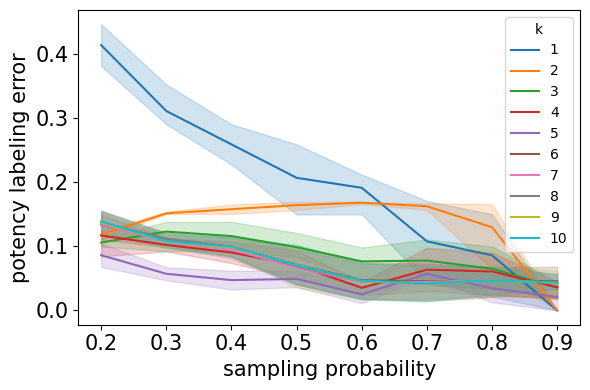

In [157]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data = df_stability_potency, x = 'prob', y='potency_diff', hue= 'nprogs', palette=sns.color_palette())

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('potency labeling error', fontsize=15);

plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# plt.gca().set_xticklabels(['25 X 25', '50 X 50', '100 X 100'], fontsize=20)
# plt.gca().set_xticklabels(['25 X 25', '50 X 50'], fontsize=20)
plt.legend(title=r'k', loc='upper right')
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_stability_potency.pdf', bbox_inches='tight')

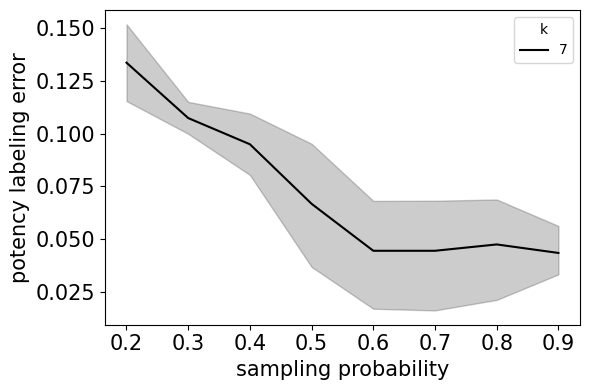

In [158]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data = df_stability_potency[df_stability_potency['nprogs'] == 7],
             x = 'prob', y='potency_diff', hue='nprogs', palette=['black'])

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('potency labeling error', fontsize=15);

plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.legend(title=r'k', loc='upper right')
# plt.gca().set_xticklabels(['25 X 25', '50 X 50', '100 X 100'], fontsize=20)
# plt.gca().set_xticklabels(['25 X 25', '50 X 50'], fontsize=20)

plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_stability_potency_k7.pdf', bbox_inches='tight')

# Figure S4

In [109]:
invitro_data_dir = '../data/larry/'
df_meta = pd.read_csv(f'{invitro_data_dir}input/stateFate_inVitro_metadata.txt', sep='\t')

In [110]:
ntypes = df_meta['Cell type annotation'].nunique()
cell_type_list = list(df_meta['Cell type annotation'].unique())
cell_type_index_dict = {cell_type: idx for idx, cell_type in enumerate(cell_type_list)}

In [111]:
barcoded_cells = []

with open(f'{invitro_data_dir}/input/stateFate_inVitro_clone_matrix.mtx', 'r') as inp:
    flag = 0
    for line in inp:
        if line.startswith('%'):
            continue
        data = line.rstrip('\n').split(' ')
        assert(len(data) == 3)
        if flag == 0:
            nclones = int(data[1])
            orig_clone_type_mat = np.zeros((nclones, ntypes))
            flag = 1
        else:
            cell_idx = int(data[0]) - 1
            clone_idx = int(data[1]) - 1
            cell_type_idx = cell_type_index_dict[df_meta.iloc[cell_idx]['Cell type annotation']]
            barcoded_cells.append(cell_idx)
            orig_clone_type_mat[clone_idx][cell_type_idx] = 1

In [112]:
df_meta_altered = df_meta.copy()

df_meta_altered['barcoded'] = 0
df_meta_altered.loc[barcoded_cells, 'barcoded'] = 1

df_meta_altered[df_meta_altered['barcoded'] == 1]['Cell type annotation'].value_counts()

df_orig_clone_type_mat = pd.DataFrame(orig_clone_type_mat, columns = cell_type_list, dtype=int)

df_collapsed_clone_type_mat = df_orig_clone_type_mat.copy()

df_collapsed_clone_type_mat['DC'] = df_collapsed_clone_type_mat['Ccr7_DC'] | df_collapsed_clone_type_mat['pDC']
df_collapsed_clone_type_mat = df_collapsed_clone_type_mat.drop(['Ccr7_DC', 'pDC'], axis=1)

In [107]:
collapse_types = {"MEP": ["Erythroid", "Meg"],
                 "CLP": ["DC", "Lymphoid"],
                 "MB": ["Monocyte", "Eos", "Baso", "Neutrophil"]}

In [108]:
for t in collapse_types:
    temp_mat = df_collapsed_clone_type_mat.copy()
    temp_mat[t] = temp_mat[collapse_types[t]].any(axis=1).astype(int)
    temp_mat = temp_mat.drop(collapse_types[t], axis = 1)
    deduplicated_collapsed_clone_type_mat, collapsed_clone_type_inverse_indices, collapsed_clone_counts = np.unique(temp_mat.values,
                                                                                                                axis=0,
                                                                                                                return_inverse=True,
                                                                                                                return_counts=True)

    df_deduplicated_collapsed_clone_type_mat = pd.DataFrame(deduplicated_collapsed_clone_type_mat,
                                                        columns = temp_mat.columns,
                                                        dtype = int)
    df_deduplicated_collapsed_clone_type_mat['counts'] = collapsed_clone_counts

    out = "_".join([t])
    # df_deduplicated_collapsed_clone_type_mat.to_csv(f'../data/larry/results/larry_subcluster/{out}.csv')